model 2, let's see why we shouldn't predict the Adj Close price.

In [11]:
import tensorflow as tf
from keras import optimizers
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler


In [17]:
start = '2000-01-01'
end = datetime(2024, 8, 7, 11, 21, 24, 633194)

sp500_data = yf.download('^GSPC', start='2000-03-14', end='2024-01-01')
sp500 = sp500_data.dropna()
print(sp500.head(3))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-03-14  1383.619995  1395.150024  1359.150024  1359.150024  1359.150024   
2000-03-15  1359.150024  1397.989990  1356.989990  1392.140015  1392.140015   
2000-03-16  1392.150024  1458.469971  1392.150024  1458.469971  1458.469971   

                Volume  
Date                    
2000-03-14  1094000000  
2000-03-15  1302800000  
2000-03-16  1482300000  


In [18]:
data=sp500_data

# Adding indicators
data['RSI']=ta.rsi(data['Adj Close'], length=14)
data['Ema_fast'] = ta.ema(data['Adj Close'], length=20)  
data['Ema_medium'] = ta.ema(data['Adj Close'], length=50) 
data['Ema_slow'] = ta.ema(data['Adj Close'], length=100)

#get the daily return
data['Target'] = data['Adj Close'].pct_change()
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
Date = data['Date']

data.drop(['Volume', 'Adj Close', 'Date'], axis=1, inplace=True)
print(data.head(3)) 



          Open         High          Low        Close        RSI     Ema_fast  \
0  1438.699951  1454.189941  1425.430054  1452.560059  47.598056  1458.763542   
1  1452.560059  1462.930054  1451.310059  1462.930054  50.819075  1459.160353   
2  1462.930054  1480.800049  1460.719971  1479.319946  55.477196  1461.080314   

    Ema_medium     Ema_slow    Target  TargetNextClose  
0  1460.836670  1456.315997  0.009634      1462.930054  
1  1460.918764  1456.446969  0.007139      1479.319946  
2  1461.640379  1456.899899  0.011203      1482.800049  


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)
data_set_scaled

array([[0.18409155, 0.1840542 , 0.18439597, ..., 0.16196251, 0.54945603,
        0.1908724 ],
       [0.18745139, 0.18617387, 0.1906864 , ..., 0.16199765, 0.53886934,
        0.1948505 ],
       [0.18996518, 0.19050772, 0.19297358, ..., 0.16211919, 0.55611742,
        0.19569518],
       ...,
       [0.98893397, 0.99177855, 0.99452388, ..., 0.96867075, 0.52653096,
        0.99636411],
       [0.99247083, 0.99194102, 0.9970638 , ..., 0.97036478, 0.51464325,
        0.99679372],
       [0.99561968, 0.99385929, 1.        , ..., 0.97203467, 0.51014368,
        0.99351219]])

In [21]:

X = []# Initialize list X to store sequences

backcandles = 30
print(data_set_scaled.shape[0])
for j in range(data.shape[1]-2):#number of features
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])#-1 the last column is the target
y=np.reshape(yi,(len(yi),1))


print(X.shape)
print(y.shape)

5888
(5858, 30, 8)
(5858, 1)


In [22]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


4686
(4686, 30, 8)
(1172, 30, 8)
(4686, 1)
(1172, 1)


In [14]:
tf.random.set_seed(20)

model = Sequential()
model.add(LSTM(units=150, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.add(Activation('linear', name='output'))

adam = optimizers.Adam()
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=X_train, y=y_train, epochs=30, batch_size=15, shuffle=True, validation_split=0.1)

Epoch 1/30


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0036 - root_mean_squared_error: 0.0508 - val_loss: 1.1878e-04 - val_root_mean_squared_error: 0.0109
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.5847e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.1419e-04 - val_root_mean_squared_error: 0.0107
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.9839e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.4336e-04 - val_root_mean_squared_error: 0.0120
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.5402e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.2816e-04 - val_root_mean_squared_error: 0.0151
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.4578e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.8243e-04 - val_root_mean_squared_error: 0.0168
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.4883e-05 - root_mean_squared_error: 0.0059 - val_loss: 3.0237e-04 - val_root_mean_squared_error: 0.0174
Epoch 7/30
28

In [15]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4409e-04 - root_mean_squared_error: 0.0231
test loss, test acc: [0.0007 0.0265]


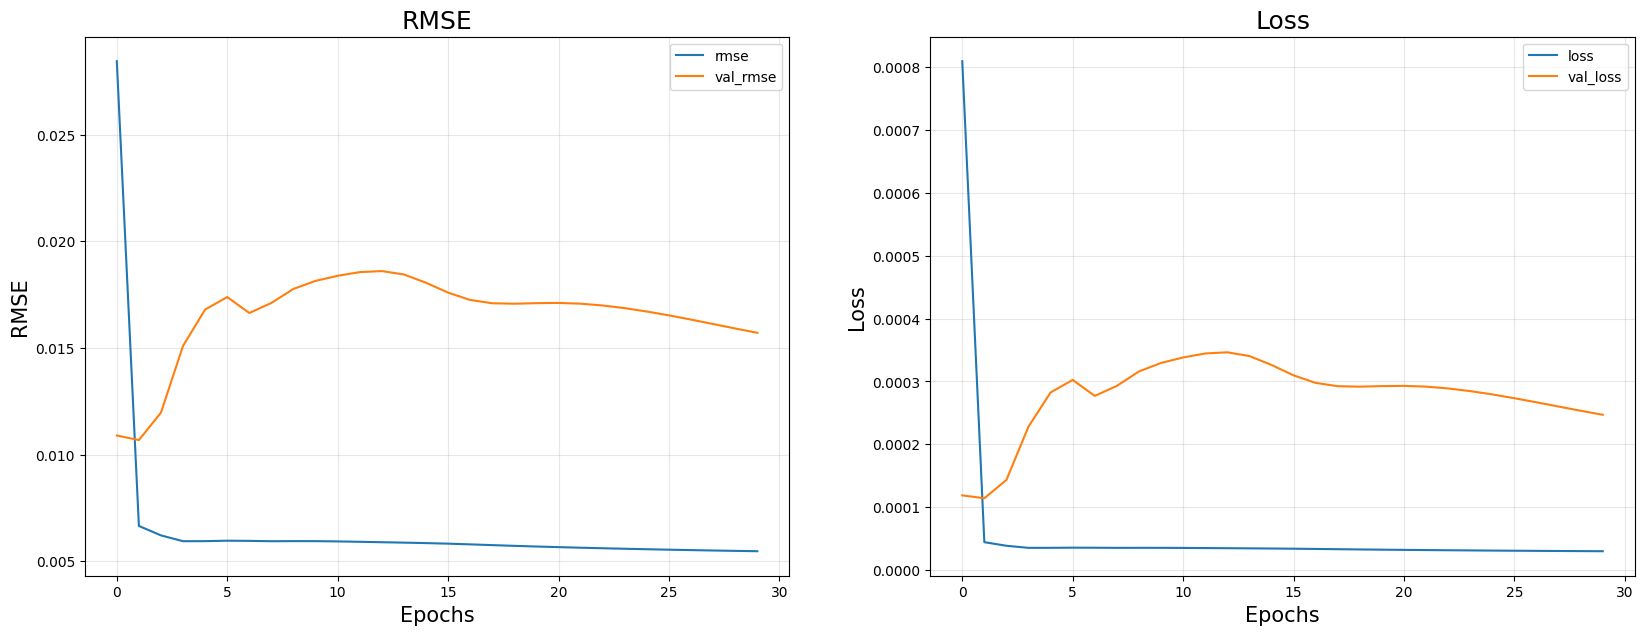

In [16]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# RMSE
plt.plot(history.epoch, history.history['root_mean_squared_error'], label="rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label="val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Loss
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


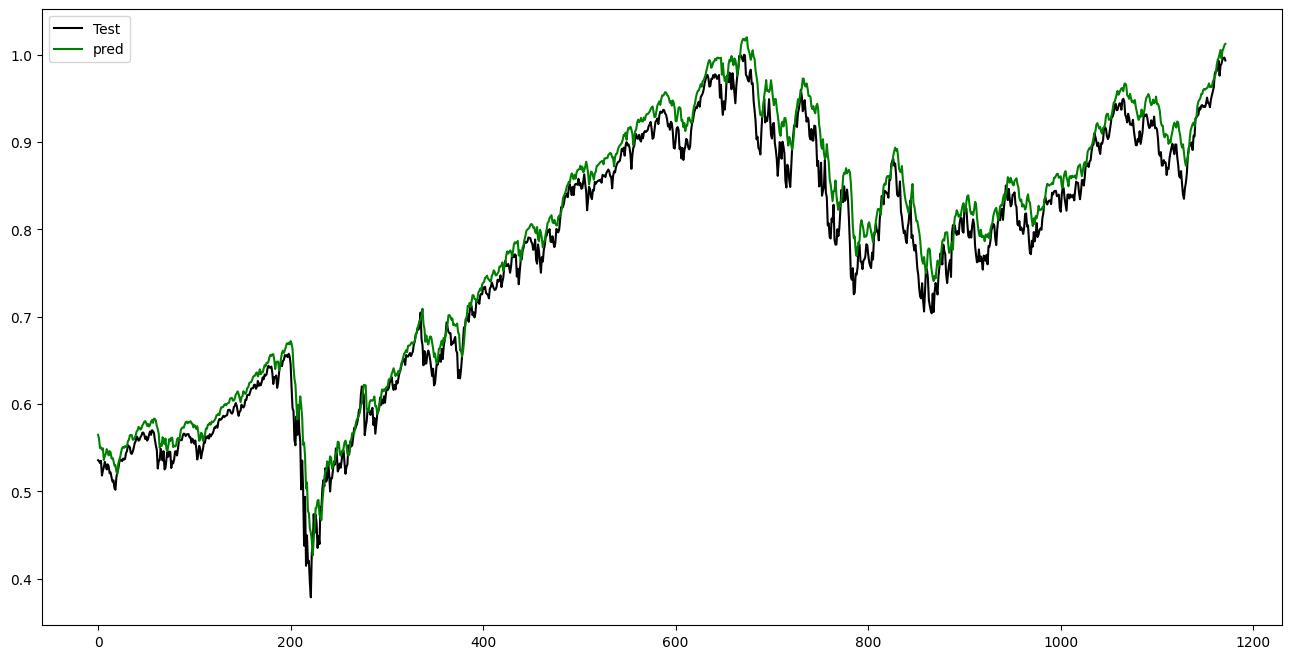

In [17]:
y_pred = model.predict(X_test)
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

We can see again, despite out my model is overfiiting, the final plots looks very satified. 

Let's then try to predict the daily return, as it conveys the same information as the next day Adj Close.

In [18]:
X = []# Initialize list X to store sequences

backcandles = 30
print(data_set_scaled.shape[0])
for j in range(data.shape[1]-2):#number of features
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-2])# -2 is the daily return column
y=np.reshape(yi,(len(yi),1))


print(X.shape)
print(y.shape)

5888
(5858, 30, 8)
(5858, 1)


In [19]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

4686
(4686, 30, 8)
(1172, 30, 8)
(4686, 1)
(1172, 1)


In [20]:
tf.random.set_seed(20)


model = Sequential()
model.add(LSTM(units=150, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.add(Activation('linear', name='output'))

adam = optimizers.Adam()
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=X_train, y=y_train, epochs=30, batch_size=15, shuffle=True, validation_split=0.1)

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0237 - root_mean_squared_error: 0.1398 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12m

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


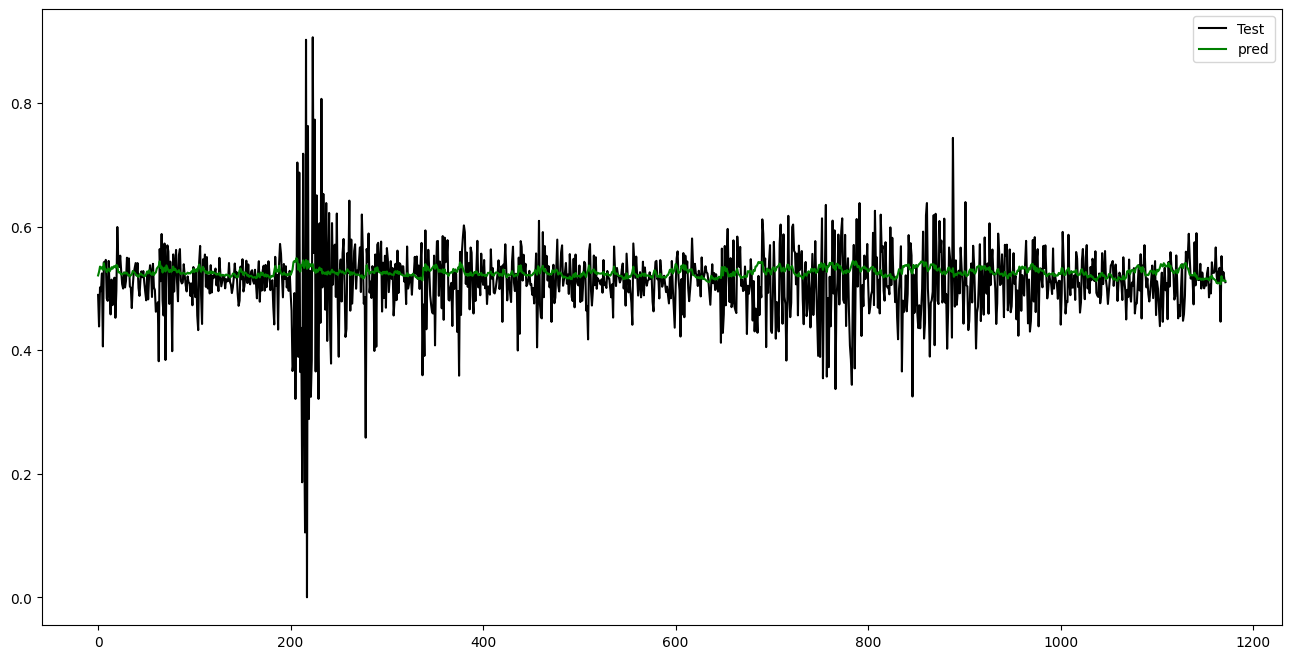

In [24]:
y_pred = model.predict(X_test)
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

We can see the model cant's capture the trend of the daily return at all. 

We should then try to predict the daily return instead of the Adj Close price:
1. **Reduces Lag Effect:** Focusing on returns helps the model capture market movements more accurately, minimizing reliance on previous prices and reducing lag.
2. **Better Focus on Market Dynamics:** Returns highlight the direction and magnitude of price changes, allowing the model to better predict market behavior.